In [1]:
# %matplotlib widget

import os
from tqdm import tqdm
from copy import deepcopy as copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from astropy.visualization import hist
from scipy.stats import gaussian_kde
import pandas as pd
import seaborn as sns


sns.set_theme(context="poster", style="ticks", palette="Set2", color_codes=True)


from astropy import units as u
from astropy.constants import L_sun
from astropy. io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Table

import warnings

warnings.filterwarnings("ignore")
# warnings.filterwarnings('ignore', category=UserWarning)


# import pyFIT3D
# print(pyFIT3D.__version__)

from pyFIT3D.common.auto_ssp_tools import auto_ssp_elines_single_main

from MaStarChecks.io import load_libraries
from MaStarChecks.preprocessing import downgrade_resolution

from neighborhood_analogs.constants import NORM_WINDOW
import neighborhood_analogs._cmdline.find_analogs

import contextlib
import sys

class DummyFile(object):
    def write(self, x): pass

@contextlib.contextmanager
def nostdout():
    save_stdout = sys.stdout
    sys.stdout = DummyFile()
    yield
    sys.stdout = save_stdout


CLASSIFIED_PATH = "../../mastar-checks/notebooks/fitting/_data/classified-mastar-v3.1.1-cleaned-v2-gsl"
CACHE_PATH = "_data/cache"
os.makedirs(CACHE_PATH, exist_ok=True)

In [2]:
spectra, catalogues = load_libraries(
    labels=["MaStar"],
    spectra_types=["FLUX", "ERROR", "SIGINST"],
    kind="classified-gsl",
    libraries_path=CLASSIFIED_PATH,
    use_cache=True, cache_label="classified-mastar", cache_path=CACHE_PATH
)

spectra_mastar = spectra["MaStar"]["FLUX"]
error_mastar = spectra["MaStar"]["ERROR"]
lsf_mastar = spectra["MaStar"]["SIGINST"]
catalogue_mastar = catalogues["MaStar"]
del spectra, catalogues

In [3]:
sna_wl = spectra_mastar.columns.values
mastar_sed = spectra_mastar.values
mastar_err = error_mastar.values
# compute SN spectrum
Lsun_per_angstroms = catalogue_mastar.FNORM.values[:, None] * (np.pi*(catalogue_mastar.DIST.values[:, None]*u.kpc).to(
    "cm") / L_sun.cgs) * np.pi*(catalogue_mastar.DIST.values[:, None]*u.kpc).to("cm")
sna_sed = (mastar_sed * Lsun_per_angstroms.value * catalogue_mastar.VCORR.values[:, None]).sum(axis=0)
sna_err = np.sqrt(((mastar_err * Lsun_per_angstroms.value * catalogue_mastar.VCORR.values[:, None])**2 * mastar_err.shape[0]).sum(axis=0))
sna_lsf = np.sqrt(((lsf_mastar * catalogue_mastar.VCORR.values[:, None])**2).sum(axis=0) * lsf_mastar.shape[0]).values

sna_sed_dg = downgrade_resolution(sna_wl, sna_sed, sigma=np.sqrt(sna_lsf.max()**2 - sna_lsf**2))

NORM_WINDOW = [5000-45, 5000+45]

ipix, fpix = np.argmin(np.abs(sna_wl-NORM_WINDOW[0])), np.argmin(np.abs(sna_wl-NORM_WINDOW[1]))
fnorm = np.mean(sna_sed_dg[ipix:fpix+1])
sna_sed /= fnorm
sna_sed_dg /= fnorm
sna_err /= fnorm

100%|##################################################| downgrading resolution: 6351/6351 [00:02<00:00, 2773.63pixel/s]


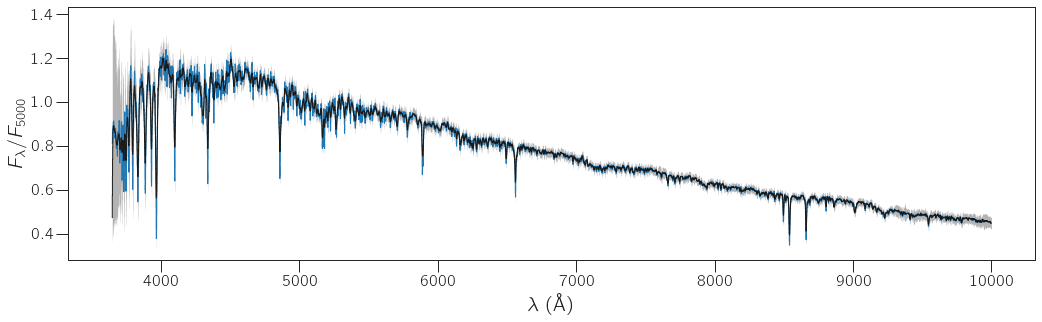

In [4]:
fig, ax = plt.subplots(figsize=(15,5))
ax.step(sna_wl, sna_sed, lw=1, color="tab:blue")
ax.step(sna_wl, sna_sed_dg, lw=1, color="0.1")
ax.fill_between(sna_wl, sna_sed-3*sna_err, sna_sed+3*sna_err, step="pre", lw=0, fc="0.7")
ax.set_xlabel(r"$\lambda$ (\AA)")
ax.set_ylabel(r"$F_\lambda/F_{%d}$" % (np.mean(NORM_WINDOW).astype(int)))
fig.tight_layout()

In [5]:
os.listdir(os.environ["FIT3D_TEMPLATES"])

['MaStar_CB19.all_1_5.fits.gz',
 'MaStar_CB19.3_1_5.fits.gz',
 'MaStar_CB19.slog_1_5.fits.gz',
 'MaStar_CB19.mixed_1_5.fits.gz',
 'MaStar_CB19.lin_1_5.fits.gz',
 'gsd61_3.fits',
 'gsd01_3.fits',
 'MaStar_CB19.log_1_5.fits.gz',
 'MaStar_CB19.gsd152_1_5.fits.gz',
 'gsd01_156.fits',
 'MaStar_CB19.12_1_5.fits.gz',
 'gsd61_156.fits']

In [6]:
N_MC = 100

sps_models = []
for i_mc in tqdm(range(N_MC), total=N_MC, desc="fitting SN spectrum", unit="fit", ascii=True):
    with nostdout():
        cf, sps = auto_ssp_elines_single_main(
            wavelength=sna_wl, flux=sna_sed_dg, eflux=sna_err,
            ssp_file=os.path.expandvars("$FIT3D_TEMPLATES/MaStar_CB19.slog_1_5.fits.gz"),
            ssp_nl_fit_file=os.path.expandvars("$FIT3D_TEMPLATES/MaStar_CB19.3_1_5.fits.gz"),
            config_file="../../lvm-dap/_fitting-data/_configs/MaNGA/auto_ssp_MaNGA_several.HII.config",
            out_file="sna-fit", sigma_inst=0.001, fit_gas=False, single_ssp=False,
            w_min=sna_wl.min(), w_max=sna_wl.max(), nl_w_min=sna_wl.min(), nl_w_max=4700,
            input_redshift=0, input_AV=0, input_sigma=0,
            delta_redshift=0.001, delta_AV=0.1, delta_sigma=1
        )
    sps_models.append(sps)

fitting SN spectrum: 100%|##########| 100/100 [3:42:29<00:00, 133.50s/fit] 


In [7]:
new_coeffs = np.array([sps_model.coeffs_norm for sps_model in sps_models]).mean(axis=0)
new_coeffs = new_coeffs / new_coeffs.sum()

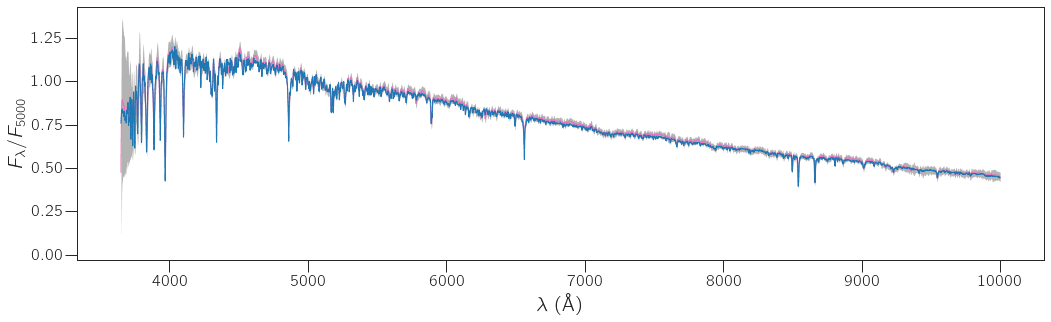

In [8]:
fig, ax = plt.subplots(figsize=(15,5))
ax.fill_between(sna_wl, sna_sed_dg-3*sna_err, sna_sed_dg+3*sna_err, step="pre", lw=0, fc="0.7")
ax.step(sna_wl, sna_sed_dg, lw=1, color="tab:pink")
ax.step(sna_wl, sps.get_best_model_from_coeffs(sps.models, new_coeffs), lw=1, color="tab:blue")
ax.set_xlabel(r"$\lambda$ (\AA)")
ax.set_ylabel(r"$F_\lambda/F_{%d}$" % (np.mean(NORM_WINDOW).astype(int)))
fig.tight_layout()


In [9]:
stellar_mass = np.divide(sps.models.mass_to_light * fnorm, new_coeffs, where=new_coeffs!=0, out=np.zeros_like(new_coeffs))

mass_share = pd.DataFrame(
    data=np.column_stack((
        (sps.models.age_models).round(2),
        np.log10(sps.models.metallicity_models/0.017).round(2),
        stellar_mass)),#np.log10(stellar_mass, where=stellar_mass!=0, out=stellar_mass))),
    columns=["age", "met", "mass"]
)
sfh_matrix = pd.pivot_table(mass_share, values="mass", index="met", columns="age").sort_index(ascending=False)

mass_age = sfh_matrix.sum(axis="index")
mass_met = sfh_matrix.sum(axis="columns")

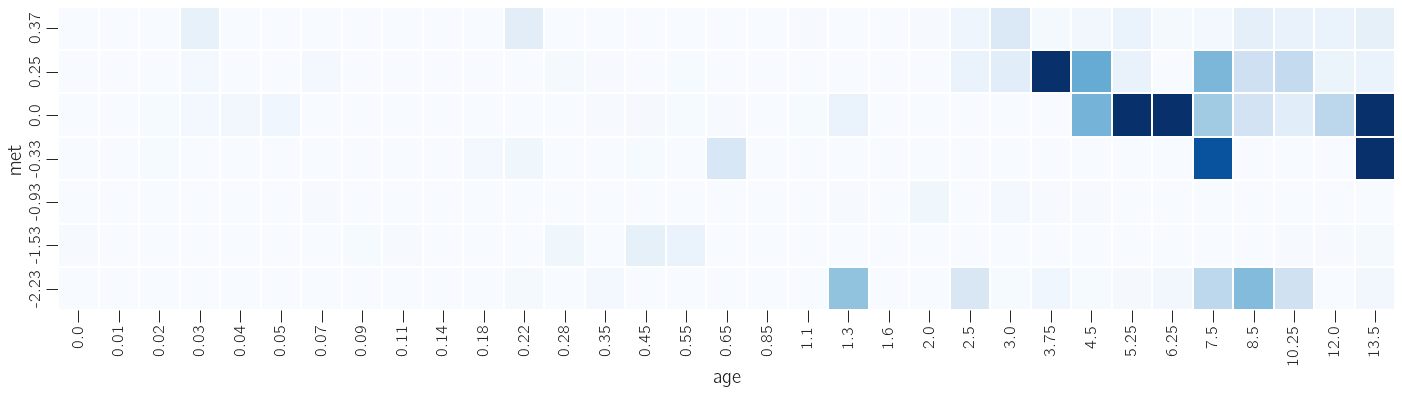

In [10]:
fig, ax = plt.subplots(figsize=(20,6))
sns.heatmap(
    sfh_matrix,
    robust=True,
    cbar=False,
    cmap="Blues",
    linewidths=0.2,
    ax=ax
)
fig.tight_layout()

In [11]:
# # the light before the light
# # the time before the light

# plt.subplots(figsize=(20,5))
# mass_age.plot(kind="bar", color="tab:blue")
# plt.ylabel("M (M$_\odot$)")
# # plt.gca().invert_xaxis()
# plt.tight_layout()

33 34 33 33
0.0 14.0


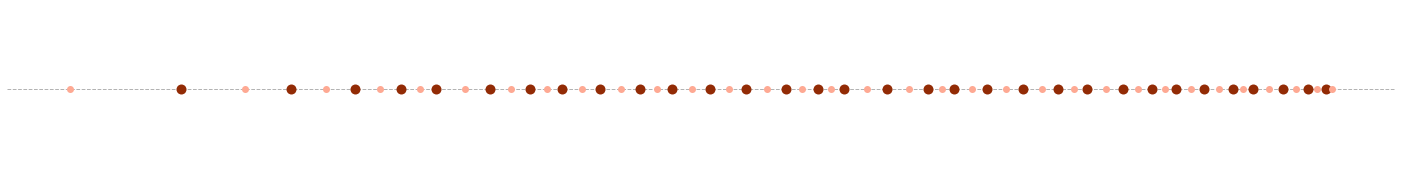

In [12]:
BB_age = 14
# time since the BB
# time_scale = (BB_age - mass_age.index)
# time shifted by the BB age
# t_scale = (BB_age-mass_age.index.max() + mass_age.index)
t_scale = mass_age.index

t_edges = np.insert((t_scale[1:]+t_scale[:-1])/2, 0, 0.0)
t_edges = np.append(t_edges, BB_age)
t_delta = np.diff(t_edges)[::-1]
print(t_scale.size, t_edges.size, t_delta.size, mass_age.size)
print(t_edges.min(), t_edges.max())
fig, ax = plt.subplots(figsize=(20,3))
ax.axhline(ls="--", lw=1, color="0.7")
ax.plot(t_scale, np.zeros_like(t_scale), "o", ms=10, color="#922B05")
ax.plot(t_edges, np.zeros_like(t_edges), "o", color="#FEA993")
ax.set_axis_off()
ax.set_xscale("log")
fig.tight_layout()

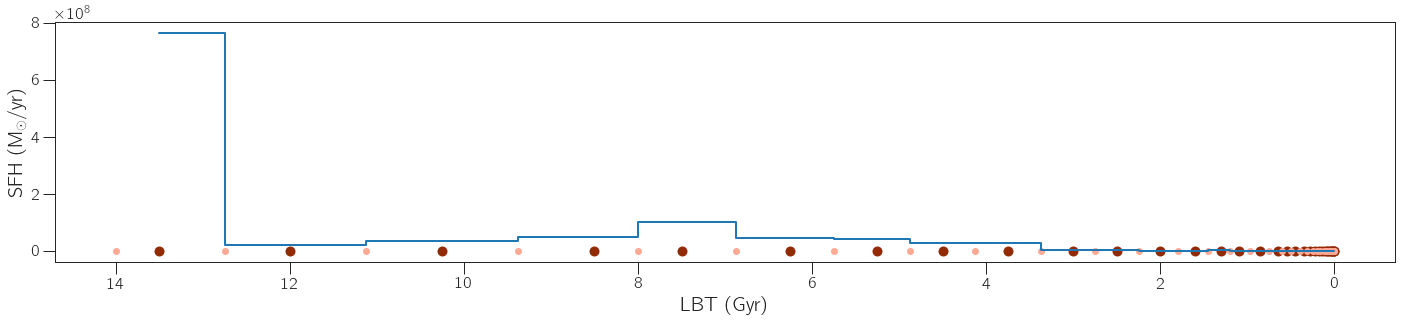

In [16]:
fig, ax = plt.subplots(figsize=(20,5))

# sfh = pd.Series(
#     index=mass_age.index,
#     data=downgrade_resolution(mass_age.index.values, mass_age.values / t_delta, sigma=(mass_age.index.values/t_delta)*np.diff(mass_age.index.values)[0])
# )
sfh = mass_age / t_delta
ax.plot(mass_age.index, np.zeros_like(mass_age.index), "o", ms=10, color="#922B05")
ax.plot(t_edges, np.zeros_like(t_edges), "o", color="#FEA993")
ax.step(sfh.index, sfh, color="tab:blue", where="mid")
ax.set_ylabel("SFH (M$_\odot/$yr)")
ax.set_xlabel("LBT (Gyr)")
ax.invert_xaxis()
# ax.set_xscale("log")
fig.tight_layout()